In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
## Help Python find our packages
import sys
sys.path.append('..')

import json
import numpy as np
import matplotlib.pyplot as plt
import domain_scoring.domain_scoring as domain_scoring

In [3]:
path = '../rated_datasets/Rotten_Tomato_Merlin_1519148528.2417703.json'

In [4]:
merlin = json.load(open(path, "r", encoding="utf8"))

In [5]:
path = '../rated_datasets/Rotten Tomato_Potato_1519142479.127663.json'

In [6]:
potato = json.load(open(path, "r", encoding="utf8"))

In [7]:
def extract_mps(data):
    i = 0
    first = True
    batches = []
    batch = []
    for probably_path in data["meta_paths"]:
        # Ignore first time_to_rate
        if first:
            first = False
            continue
        i += 1
        if i == 6:
            # Ignore time_to_rate
            i = 0
            batches.append(batch)
            batch = []
        else:
            if 'time_to_rate' not in probably_path.keys():
                batch.append(probably_path)
    return batches

In [8]:
def construct_graph(batches):
    ## Construct rating graph
    from util.datastructures import MetaPathRatingGraph, MetaPath
    graph = MetaPathRatingGraph()

    for batch in batches:
        #ordered = sorted(batch, key=lambda x: float(x['rating']))
        for metapath in batch:
            for another_metapath in batch:
                if metapath is another_metapath:
                    continue
                if float(metapath['rating']) <= float(another_metapath['rating']):
                    graph.add_user_rating(MetaPath.from_list(another_metapath['metapath']), MetaPath.from_list(metapath['metapath']), 
                                          distance=float(another_metapath['rating']) - float(metapath['rating']))
    return graph

In [9]:
## Clean up data // remove time_to_rate from array of ratings.
def clean_up(data):
    batches = extract_mps(data)
    return batches, construct_graph(batches)

In [10]:
p_batches, p_graph = clean_up(potato)
m_batches, m_graph = clean_up(merlin)

In [11]:
domain_score = domain_scoring.DomainScoringRegressor()

In [12]:
from sklearn.linear_model import ARDRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor

In [20]:
# Configure other predictor and transformer
domain_score.vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern='\\b\\w+\\b')
domain_score.classifier = RandomForestRegressor(random_state=42)

In [21]:
domain_score.fit(m_graph, test_size=0.3)

Test accuracy is 0.3898305084745763
R^2 is 0.6858428553949141


In [22]:
domain_score.fit(p_graph, test_size=0.3)

Test accuracy is 0.3157894736842105
R^2 is 0.7736986555155622


Feature ranking:
1. feature 8 (0.345370)
2. feature 2 (0.245315)
3. feature 4 (0.067725)
4. feature 6 (0.049114)
5. feature 5 (0.043297)
6. feature 9 (0.041178)
7. feature 0 (0.040368)
8. feature 11 (0.036193)
9. feature 7 (0.035172)
10. feature 10 (0.033848)
11. feature 3 (0.033179)
12. feature 1 (0.029241)


(-1, 12)

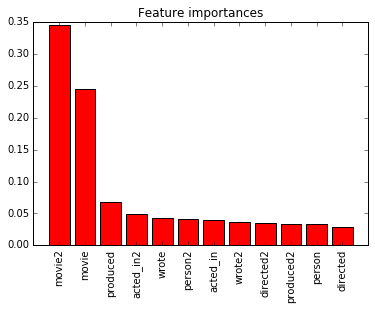

In [16]:
importances = domain_score.classifier.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(domain_score.classifier.feature_importances_)):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(domain_score.classifier.feature_importances_)), importances[indices],
       color="r", align="center")
a = list(domain_score.vectorizer.vocabulary_.values())
a.extend([i + len(list(domain_score.vectorizer.vocabulary_.values())) for i in list(domain_score.vectorizer.vocabulary_.values())])

features = list(domain_score.vectorizer.vocabulary_.keys())
features.extend([i + '2' for i in list(domain_score.vectorizer.vocabulary_.keys())])
features_ordered = [features[a.index(i)] for i in indices]

plt.xticks(range(0,len(features_ordered)), 
           features_ordered,
          rotation=90)
plt.xlim([-1, len(domain_score.classifier.feature_importances_)])
